In [19]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.io import readsav
from astropy.io import fits
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
from scipy.interpolate import interp1d
import h5py

In [20]:
dpath_clusters ='/mn/stornext/d9/souvikb/K_means_results/'
dpath = '/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/crispex/09:12:00/'

In [21]:
cc=pickle.load(open(dpath_clusters+'kmeans_training.pickle','rb'))
cluster_mask = fits.getdata(dpath_clusters+'clusters_mask.fits',ext=0)

In [22]:
wave_H= readsav(dpath+'spectfile.6563.idlsave')
wave_H=wave_H['spect_pos'][:31]
wave_H_dopp = 3e5*((wave_H-6563.)/6563.0)
wave_Ca =readsav(dpath+'spectfile.3950.idlsave')
wave_Ca=wave_Ca['spect_pos'][:41]
wave_Ca_dopp = 3e5*((wave_Ca-3933.67)/3933.67)

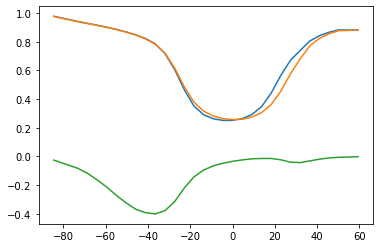

In [6]:
plt.plot(wave_H_dopp,cc[24,41:])
plt.plot(wave_H_dopp,cc[40,41:])
plt.plot(wave_H_dopp,(cc[48,41:]-cc[40,41:]))
diff_profile_spicule = (cc[48,41:]-cc[40,41:])
#diff_profile_ref = np.abs(cc[40,40:]-cc[40,40:])

## RP--40 is our rest profile. 

## Algorithm for extracting RBE and RRE RPs
1. Compute the differential profile as in Rouppe van der Voort et al. (2009) for each RP.
2. Compute the velocity of each RP by computing the position of the COG for each of the differential profile. 
3. Compute the H-alpha line width for each of the RPs using the technique as in Cauzzi et al. (2009).
4. Plot a scatter between the line width and the Velocity obtained by the COG. 

In [321]:
wav_indices =wave_H_dopp.shape
wt_I = np.zeros((50,wav_indices[0]))
I = wt_I*0
lam_cog = np.zeros(50)
for centers in range(50):
    diff_profile_spicule = np.abs(cc[centers,41:]-cc[40,41:]) # computing the differential profile.
    for i in range(31):
        wt_I[centers,i] = wave_H_dopp[i]*diff_profile_spicule[i]
        I[centers,i] = diff_profile_spicule[i]
    lam_cog[centers] = np.sum(wt_I[centers,:])/np.sum(I[centers,:])
# cog = np.sum(wt_I)/np.sum(I)

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


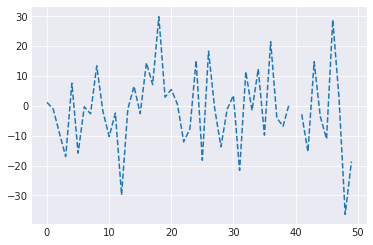

In [323]:
plt.plot(lam_cog,'--')

In [139]:
np.where(lam_cog>17) #[18,46,26,36,8,16]---[12,48,49,25,11,5]

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


(array([ 8, 16, 18, 24, 26, 34, 36, 43, 46]),)

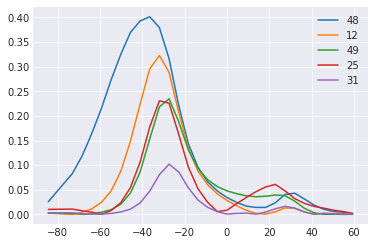

In [351]:
plt.plot(wave_H_dopp,np.abs(cc[48,41:]-cc[40,41:]),label='48')
plt.plot(wave_H_dopp,np.abs(cc[12,41:]-cc[40,41:]),label='12')
plt.plot(wave_H_dopp,np.abs(cc[49,41:]-cc[40,41:]),label='49')
plt.plot(wave_H_dopp,np.abs(cc[25,41:]-cc[40,41:]),label='25')
plt.plot(wave_H_dopp,np.abs(cc[31,41:]-cc[40,41:]),label='31')
plt.legend()
plt.grid('on')

In [23]:
wave_H_dopp_new = np.zeros(len(wave_H_dopp))
for k in range(len(wave_H_dopp)):
    if wave_H_dopp[k]>0:
        wave_H_dopp_new[k] = wave_H_dopp[k]+4.9
    else:
        wave_H_dopp_new[k] = wave_H_dopp[k]-4.9
        

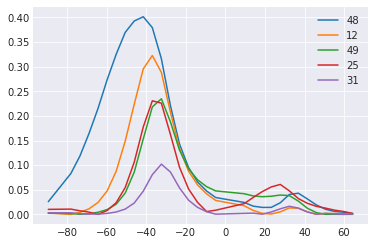

In [359]:
plt.plot(wave_H_dopp_new,np.abs(cc[48,41:]-cc[40,41:]),label='48')
plt.plot(wave_H_dopp_new,np.abs(cc[12,41:]-cc[40,41:]),label='12')
plt.plot(wave_H_dopp_new,np.abs(cc[49,41:]-cc[40,41:]),label='49')
plt.plot(wave_H_dopp_new,np.abs(cc[25,41:]-cc[40,41:]),label='25')
plt.plot(wave_H_dopp_new,np.abs(cc[31,41:]-cc[40,41:]),label='31')
plt.legend()
plt.grid('on')

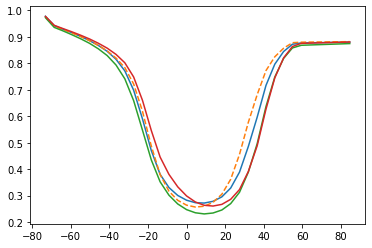

In [137]:
plt.plot(wave_H_dopp,cc[43,41:])
plt.plot(wave_H_dopp,cc[40,41:],'--')
plt.plot(wave_H_dopp,cc[32,41:])
plt.plot(wave_H_dopp,cc[8,41:])

## H-alpha line core width 

In [24]:
def lp_halpha_core_width(sp,ll):
    """
    Measures core width of Halpha line profile
    sp : spectrum
    ll : wavelength positions relative to line center, in AA
    returns corewidth : width in AA (units ll)
    """
    if np.min(ll) > -0.9 or np.max(ll) < 0.9:
        print("spectral range should be in AA and at least cover -0.9 to +0.9")
        print(ll)
    
    nl = len(ll)
    lrange = np.max(ll)-np.min(ll)
    spmax = np.max(sp)
    spmin = np.min(sp)
    maxp = np.argmax(sp)
    minp = np.argmin(sp)
    corewidth =0.
    if minp > 1 and minp < nl-2:
        m0 = np.min(np.abs(ll+0.9))
        m1 = np.min(np.abs(ll-0.9))
        l0 = np.argmin(np.abs(ll+0.9))
        l1 = np.argmin(np.abs(ll-0.9))
        if m0 < 0.001 and m1 < 0.001:
            avgw = np.mean([sp[l0],sp[l1]])
        else:
            y1 = sp[0:minp-1]
            x1 = ll[0:minp-1]
            f1 = interp1d(x1,y1)
            sp0 = f1(-0.9)
            y2 = sp[minp+1:]
            x2 = ll[minp+1:]
            f2 = interp1d(x2,y2)
            sp1 = f2(0.9)
            avgw = np.mean([sp0,sp1])
        y3 = ll[0:minp-1]
        x3 = sp[0:minp-1]
        f3 =interp1d(x3,y3)
        ll0 = f3((avgw-spmin)/2.+spmin)
        y4 = ll[minp+1:]
        x4 = sp[minp+1:]
        f4 = interp1d(x4,y4)
        ll1 = f4((avgw-spmin)/2.+spmin)
        corewidth=ll1-ll0
        if np.isfinite(corewidth)==0:
            corewidth =0
        if corewidth > lrange:
            corewidth = lrange
    return corewidth

In [25]:
ll=wave_H-wave_H[17]


In [26]:
ll

array([-1.85000014, -1.60000002, -1.50000012, -1.4000001 , -1.30000007,
       -1.20000005, -1.10000002, -1.        , -0.90000004, -0.80000001,
       -0.70000005, -0.60000002, -0.5       , -0.40000001, -0.30000001,
       -0.2       , -0.1       ,  0.        ,  0.1       ,  0.2       ,
        0.30000001,  0.40000001,  0.5       ,  0.60000002,  0.70000005,
        0.80000001,  0.90000004,  1.        ,  1.10000002,  1.20000005,
        1.30000007])

In [27]:
sp =cc[48,41:]

In [28]:
lp_halpha_core_width(sp,ll)

1.3570407287342232

In [356]:
lc_width = np.zeros(50)
new_lam_cog = lc_width*0
for centers in range(50):
    if centers == 13:
        continue
    sp = cc[centers,41:]
    lc_width[centers] = lp_halpha_core_width(sp,ll)
    if lam_cog[centers]>0:
        new_lam_cog[centers] = lam_cog[centers]+5
    else:
        new_lam_cog[centers] = lam_cog[centers]-5

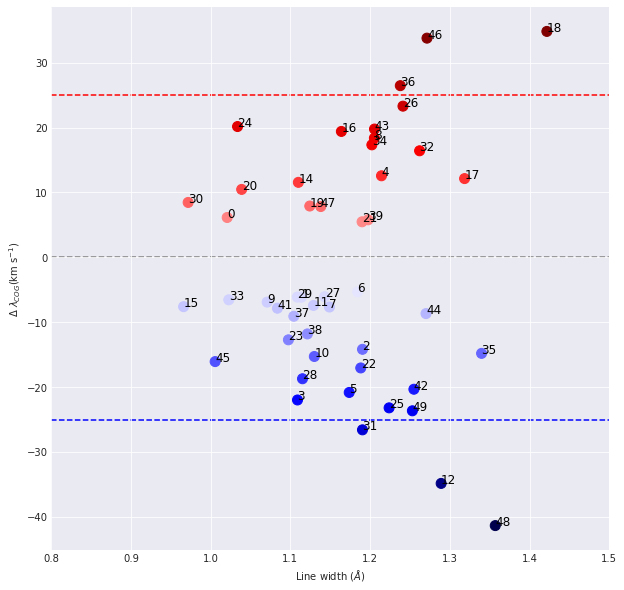

In [357]:
plt.style.use('seaborn-darkgrid')
#yticks=[-40,-25,-15,0,15,25,35]
colors = new_lam_cog
RP = np.arange(50)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(lc_width, new_lam_cog, s =100.,c=colors,marker='o',cmap='seismic',alpha=1)
ax.set_xlabel(r'Line width ($\AA$)')
ax.set_ylabel(r'$\Delta$ $\lambda_{COG}$(km s$^{-1}$)')
ax.axhline(y=0,color='gray',linestyle='--',zorder=-1)
ax.axhline(y=25,color='red',linestyle='--',zorder=-1)
ax.axhline(y=-25,color='blue',linestyle='--',zorder=-1)
ax.set_xlim([0.8,1.5])
#ax.set_yticks(yticks)
for i, txt in enumerate(RP):
    if i == 13:
        continue
    ax.annotate(txt, (lc_width[i], new_lam_cog[i]),size=12,color='black')
#    ax.grid('on')
#plt.savefig('/mn/stornext/d9/souvikb/paper4_images/COG_vs_Width.png')

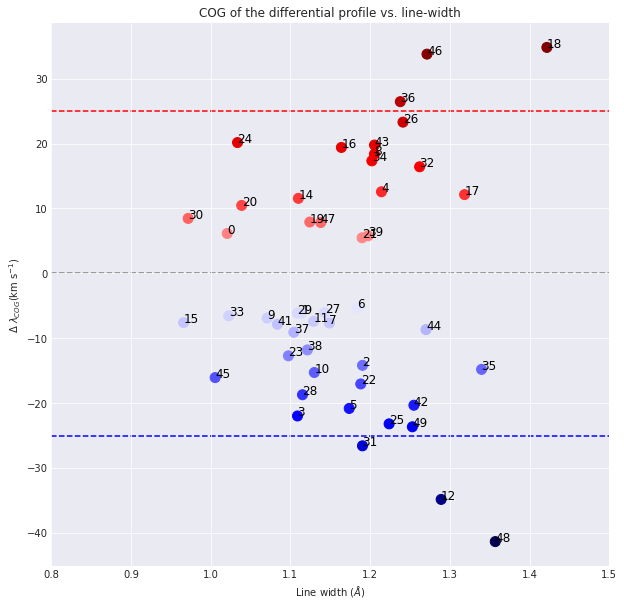

In [349]:
plt.style.use('seaborn-darkgrid')
#yticks=[-40,-25,-15,0,15,25,35]
colors = new_lam_cog
RP = np.arange(50)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(lc_width, new_lam_cog, s =100.,c=colors,marker='o',cmap='seismic',alpha=1)
ax.set_xlabel(r'Line width ($\AA$)')
ax.set_ylabel(r'$\Delta$ $\lambda_{COG}$(km s$^{-1}$)')
ax.axhline(y=0,color='gray',linestyle='--',zorder=-1)
ax.axhline(y=25,color='red',linestyle='--',zorder=-1)
ax.axhline(y=-25,color='blue',linestyle='--',zorder=-1)
ax.set_xlim([0.8,1.5])
ax.set_title('COG of the differential profile vs. line-width')
#ax.set_yticks(yticks)
for i, txt in enumerate(RP):
    if i == 13:
        continue
    ax.annotate(txt, (lc_width[i], new_lam_cog[i]),size=12,color='black')
#    ax.grid('on')
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/COG_diff_vs_Width.png')

## Same method but just with the maximum of the differential profile

In [394]:
diff_max = np.zeros(50)
for centers in range(50):
    if centers == 40:
        continue
    diff_profile_spicule = np.abs(cc[centers,41:]-cc[40,41:]) # computing the differential profile.
    diff_max[centers] = wave_H_dopp[np.argmax(diff_profile_spicule)]

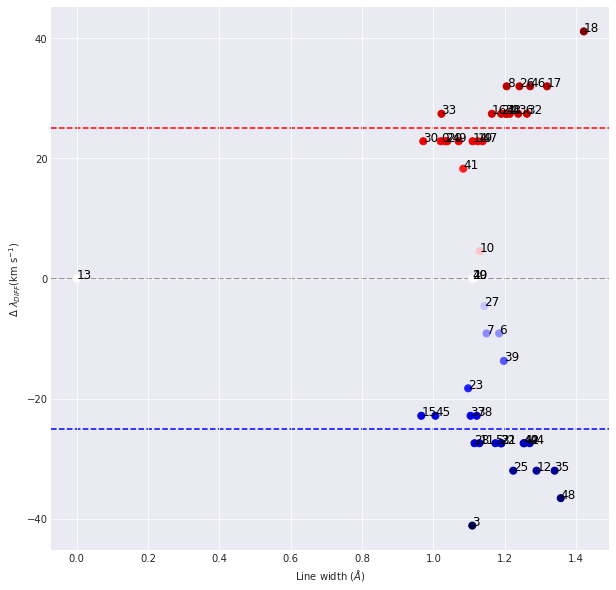

In [395]:
plt.style.use('seaborn-darkgrid')
#yticks=[-40,-25,-15,0,15,25,35]
colors = diff_max
RP = np.arange(50)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(lc_width, diff_max, s =50.,c=colors,marker='o',cmap='seismic',alpha=1)
ax.set_xlabel(r'Line width ($\AA$)')
ax.set_ylabel(r'$\Delta$ $\lambda_{DIFF}$(km s$^{-1}$)')
ax.axhline(y=0,color='gray',linestyle='--',zorder=-1)
ax.axhline(y=25,color='red',linestyle='--',zorder=-1)
ax.axhline(y=-25,color='blue',linestyle='--',zorder=-1)
#ax.set_xlim([0.8,1.5])
#ax.set_yticks(yticks)
for i, txt in enumerate(RP):
    ax.annotate(txt, (lc_width[i], diff_max[i]),size=12,color='black')
#    ax.grid('on')

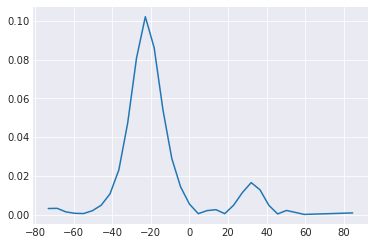

In [258]:
plt.plot(wave_H_dopp,np.abs(cc[31,41:]-cc[40,41:]))

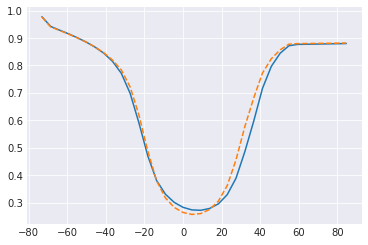

In [260]:
plt.plot(wave_H_dopp,cc[43,41:])
plt.plot(wave_H_dopp,cc[40,41:],'--')

In [264]:
wave_H[10]-wave_H[11]

-0.10000002384185791

In [338]:
wt_I = np.zeros((50,wav_indices[0]))
I =wt_I*0.
lam_cog1 =np.zeros((50))
for centers in range(50):
    for i in range(31):
        wt_I[centers,i] = wave_H_dopp[i]*np.abs(cc[centers,41]-cc[centers,41+i])
        I[centers,i] = np.abs(cc[centers,41]-cc[centers,41+i])
    lam_cog1[centers] = np.sum(wt_I[centers,:])/np.sum(I[centers,:])

In [342]:
np.where(lam_cog1<0)

(array([ 0,  1,  2,  3,  5,  7,  9, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22,
        24, 25, 27, 28, 29, 30, 31, 33, 35, 37, 40, 42, 44, 47, 48, 49]),)

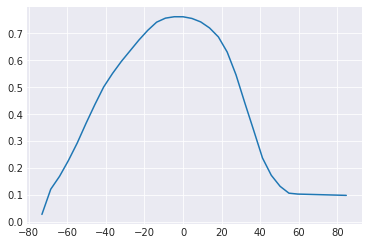

In [282]:
plt.plot(wave_H_dopp,np.abs(cc[48,41]-cc[48,41:]))

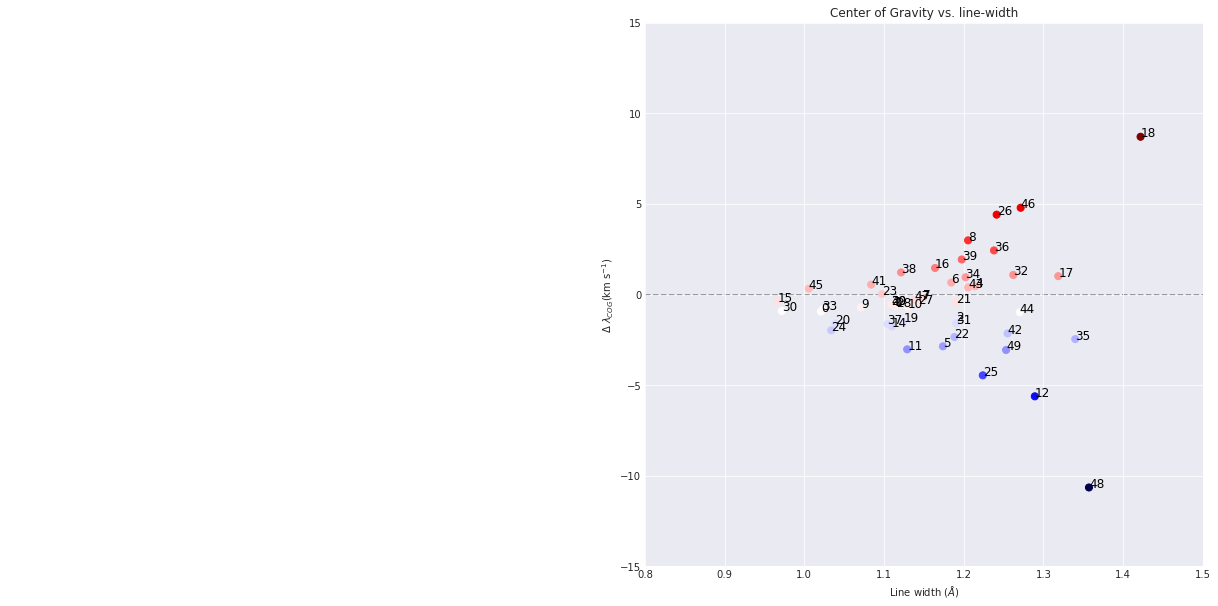

In [350]:
plt.style.use('seaborn-darkgrid')
#yticks=[-40,-25,-15,0,15,25,35]
colors = lam_cog1
RP = np.arange(50)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(lc_width, lam_cog1, s =50.,c=colors,marker='o',cmap='seismic',alpha=1)
ax.set_xlabel(r'Line width ($\AA$)')
ax.set_ylabel(r'$\Delta$ $\lambda_{COG}$(km s$^{-1}$)')
ax.axhline(y=0,color='gray',linestyle='--',zorder=-1)
ax.axhline(y=25,color='red',linestyle='--',zorder=-1)
ax.axhline(y=-25,color='blue',linestyle='--',zorder=-1)
ax.set_xlim([0.8,1.5])
ax.set_ylim([-15,15])
ax.set_title('Center of Gravity vs. line-width')
#ax.set_yticks(yticks)
for i, txt in enumerate(RP):
    ax.annotate(txt, (lc_width[i], lam_cog1[i]),size=12,color='black')
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/COG_vs_Width.png')

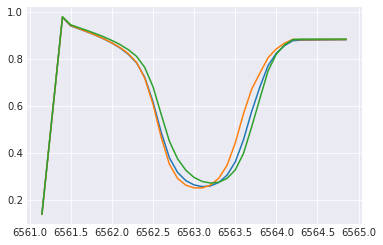

In [291]:
plt.plot(wave_H,cc[40,40:])
plt.plot(wave_H,cc[24,40:])
plt.plot(wave_H,cc[38,40:])

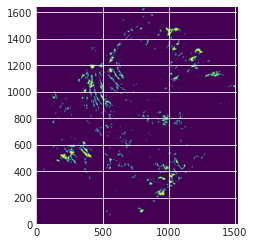

In [290]:
plt.imshow(cluster_mask[:,:,165]==24,origin='lower',cmap='viridis')
plt.grid('off')

In [292]:
np.argmin(cc[40,41:])

17

In [293]:
wave_H[16]

6562.89999999851

In [295]:
a=[0,1,2,3,4,5,6,7]
len(a)

8

In [306]:
(a[:7])

[0, 1, 2, 3, 4, 5, 6]

In [297]:
range(7)

range(0, 7)

In [307]:
for i in range(6):
    print(a[i])

0
1
2
3
4
5


In [311]:
wave_H[:31]

array([6561.14999986, 6561.39999998, 6561.49999988, 6561.5999999 ,
       6561.69999993, 6561.79999995, 6561.89999998, 6562.        ,
       6562.09999996, 6562.19999999, 6562.29999995, 6562.39999998,
       6562.5       , 6562.59999999, 6562.69999999, 6562.8       ,
       6562.9       , 6563.        , 6563.1       , 6563.2       ,
       6563.30000001, 6563.40000001, 6563.5       , 6563.60000002,
       6563.70000005, 6563.80000001, 6563.90000004, 6564.        ,
       6564.10000002, 6564.20000005, 6564.30000007])

In [312]:
cc[40,41:].shape

(31,)

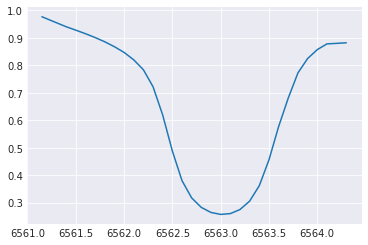

In [315]:
plt.plot(wave_H[:31],cc[40,41:])

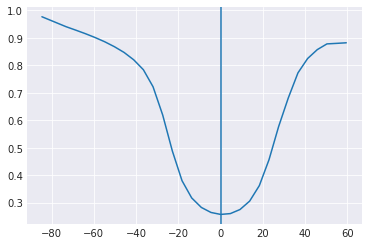

In [319]:
plt.plot(wave_H_dopp,cc[40,41:])
plt.axvline(x=0)

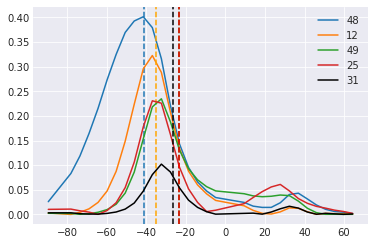

In [371]:
plt.plot(wave_H_dopp_new,np.abs(cc[48,41:]-cc[40,41:]),label='48')
plt.axvline(x=new_lam_cog[48],linestyle='--')
plt.plot(wave_H_dopp_new,np.abs(cc[12,41:]-cc[40,41:]),label='12')
plt.axvline(x=new_lam_cog[12],linestyle='--',color='orange')
plt.plot(wave_H_dopp_new,np.abs(cc[49,41:]-cc[40,41:]),label='49')
plt.axvline(x=new_lam_cog[49],linestyle='--',color='green')
plt.plot(wave_H_dopp_new,np.abs(cc[25,41:]-cc[40,41:]),label='25')
plt.axvline(x=new_lam_cog[25],linestyle='--',color='red')
plt.plot(wave_H_dopp_new,np.abs(cc[31,41:]-cc[40,41:]),label='31',color='black')
plt.axvline(x=new_lam_cog[31],linestyle='--',color='black')
plt.legend()
plt.grid('on')
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/RBE_Diff_profiles_marked_COG.png')

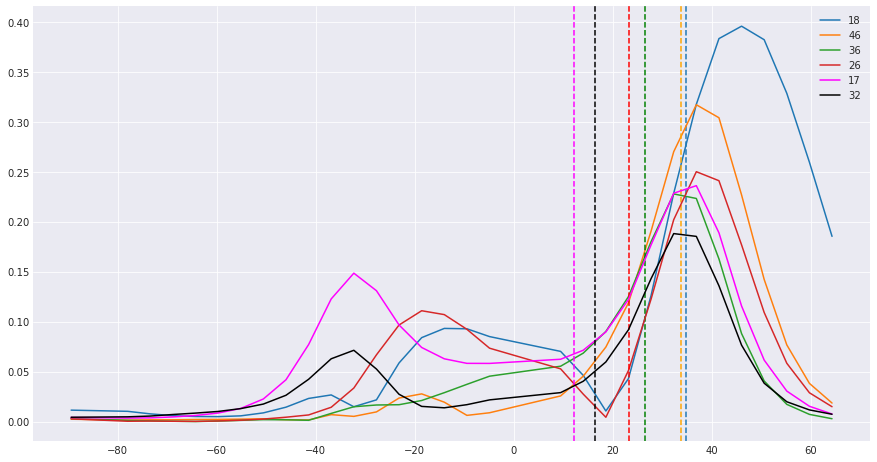

In [393]:
plt.figure(figsize=(15,8))
plt.plot(wave_H_dopp_new,np.abs(cc[18,41:]-cc[40,41:]),label='18')
plt.axvline(x=new_lam_cog[18],linestyle='--')
plt.plot(wave_H_dopp_new,np.abs(cc[46,41:]-cc[40,41:]),label='46')
plt.axvline(x=new_lam_cog[46],linestyle='--',color='orange')
plt.plot(wave_H_dopp_new,np.abs(cc[36,41:]-cc[40,41:]),label='36')
plt.axvline(x=new_lam_cog[36],linestyle='--',color='green')
plt.plot(wave_H_dopp_new,np.abs(cc[26,41:]-cc[40,41:]),label='26')
plt.axvline(x=new_lam_cog[26],linestyle='--',color='red')
plt.plot(wave_H_dopp_new,np.abs(cc[17,41:]-cc[40,41:]),label='17',color='magenta')
plt.axvline(x=new_lam_cog[17],linestyle='--',color='magenta')
plt.plot(wave_H_dopp_new,np.abs(cc[32,41:]-cc[40,41:]),label='32',color='black')
plt.axvline(x=new_lam_cog[32],linestyle='--',color='black')
plt.legend()
plt.grid('on')
#plt.savefig('/mn/stornext/d9/souvikb/paper4_images/RRE_Diff_profiles_marked_COG.png')

# With the fucking paper indices number!!!!


In [375]:
cluster_centers_new = h5py.File(dpath_clusters+'reformed_cc.hdf5','r')
data = np.array(cluster_centers_new['cc_new'])

In [376]:
data.shape

(50, 72)

In [377]:
cc.shape

(50, 72)

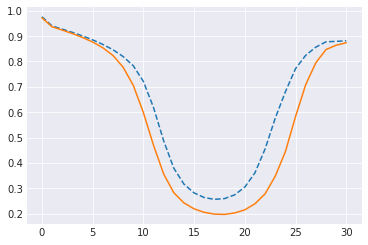

In [383]:
plt.plot(cc[40,41:],'--')
plt.plot(data[24,41:])

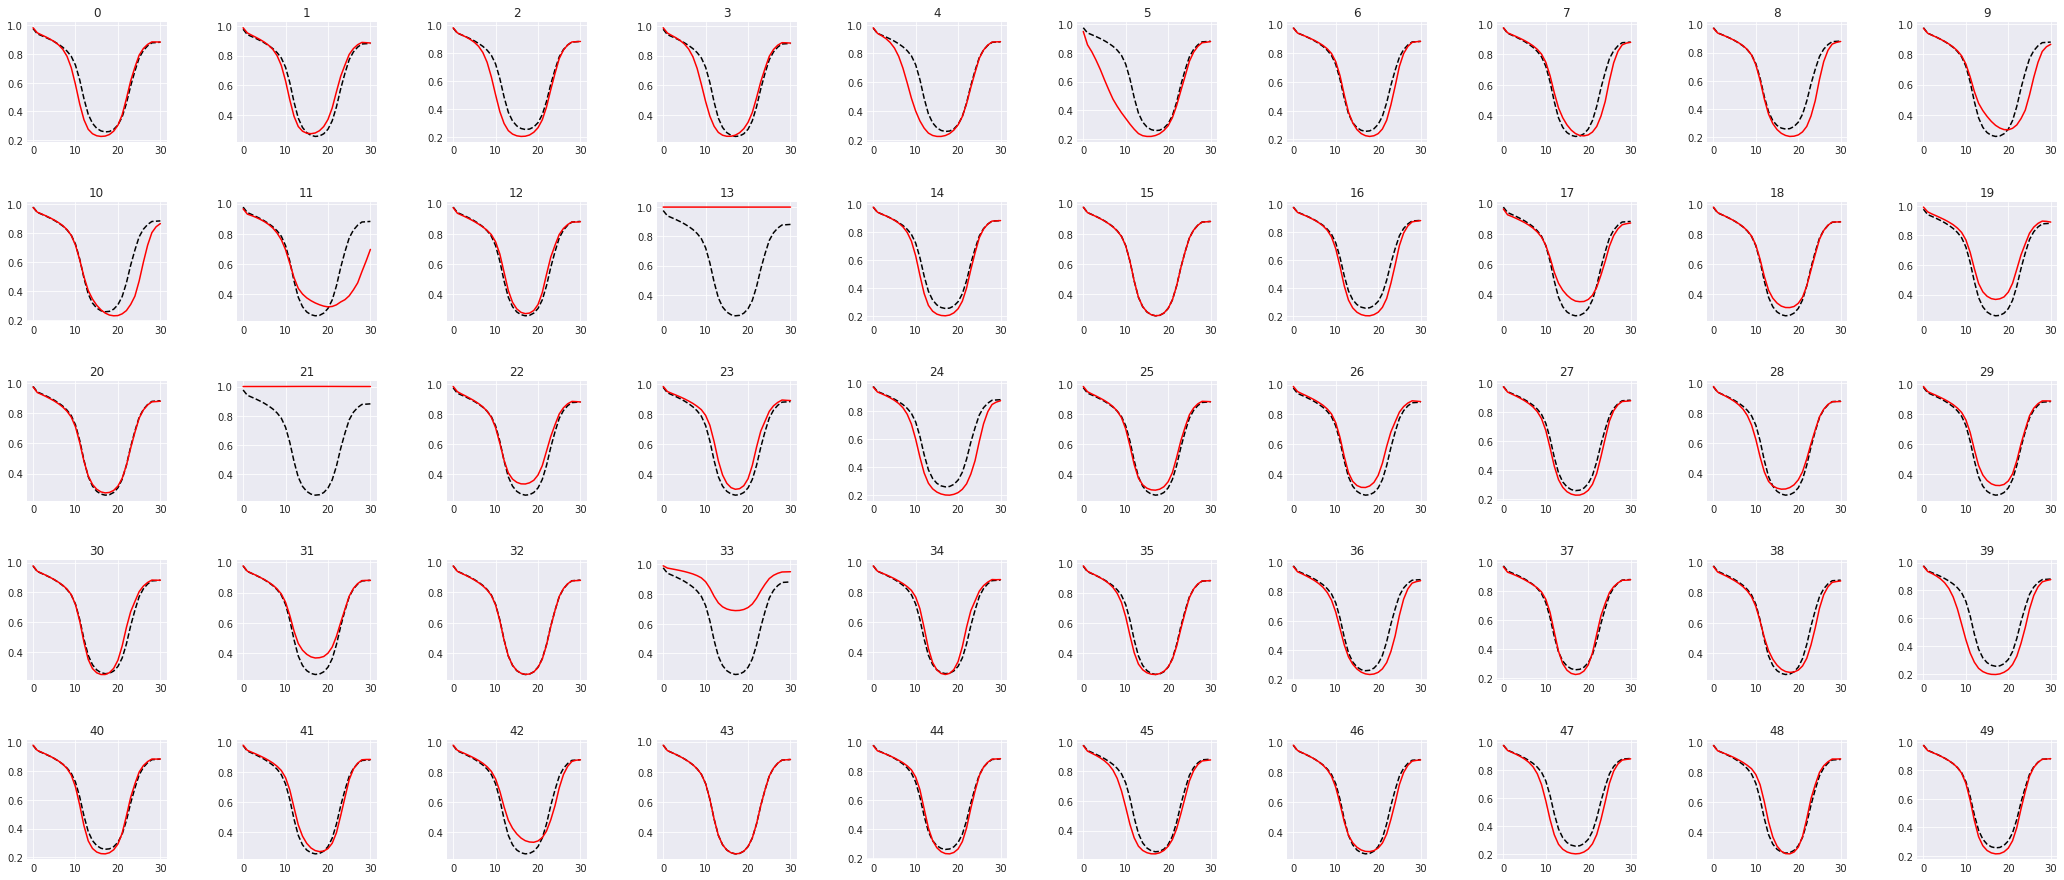

In [387]:
fig, axs = plt.subplots(5,10, figsize=(30, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5,left=0.05,right=0.99,top=0.9)

axs = axs.ravel()
for i in range(50):
    axs[i].plot(cc[40,41:],color='black',linestyle='dashed')
    axs[i].plot(data[i,41:],color='red')
    axs[i].set_title(str(i))

#plt.tight_layout()
plt.show()

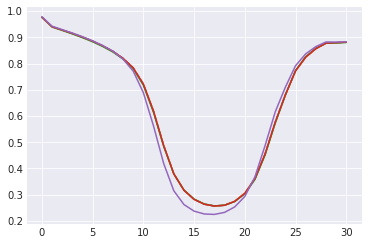

In [391]:
plt.plot(cc[40,41:],'--')
plt.plot(data[15,41:])
plt.plot(data[32,41:])
plt.plot(data[43,41:])
plt.plot(data[40,41:])

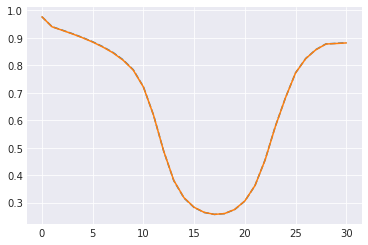

In [396]:
plt.plot(cc[40,41:],'--')
plt.plot(cc[3,41:])

In [397]:
cc.shape

(50, 72)

In [11]:
paper_cc = cc*0

In [12]:
paper_cc.shape

(50, 72)

In [161]:
# paper_cc[0,:]= cc[5,:]
# paper_cc[1,:]= cc[11,:]
#----RBEs------
paper_cc[0,:] =cc[25,:]
paper_cc[1,:] =cc[49,:]
paper_cc[2,:] =cc[12,:]
paper_cc[3,:] =cc[48,:]

#-----RREs-----
paper_cc[4,:] =cc[26,:]
paper_cc[5,:] =cc[36,:]
paper_cc[6,:] =cc[46,:]
paper_cc[7,:] =cc[18,:]

#-----Earlier shadows----
paper_cc[8,:]= cc[5,:]
paper_cc[9,:] =cc[8,:]
paper_cc[10,:]=cc[11,:]
paper_cc[11,:]=cc[16,:]

#------Rest of the RPs---
paper_cc[12,:] =cc[0,:]
paper_cc[13,:]=cc[1,:]
paper_cc[14,:]=cc[2,:]
paper_cc[15,:]=cc[3,:]
paper_cc[16,:]=cc[4,:]
paper_cc[17,:]=cc[6,:]
paper_cc[18,:]=cc[7,:]
paper_cc[19,:]=cc[9,:]
paper_cc[20,:]=cc[10,:]
paper_cc[21,:]=cc[13,:]

paper_cc[22,:]=cc[14,:]
paper_cc[23,:]=cc[15,:]
paper_cc[24,:]=cc[17,:]
paper_cc[25,:]=cc[19,:]
paper_cc[26,:]=cc[20,:]
paper_cc[27,:]=cc[21,:]
paper_cc[28,:]=cc[22,:]
paper_cc[29,:]=cc[23,:]
paper_cc[30,:]=cc[24,:]

paper_cc[31,:]=cc[27,:]
paper_cc[32,:]=cc[28,:]
paper_cc[33,:]=cc[29,:]
paper_cc[34,:]=cc[30,:]
paper_cc[35,:]=cc[31,:]
paper_cc[36,:]=cc[32,:]
paper_cc[37,:]=cc[33,:]
paper_cc[38,:]=cc[34,:]
paper_cc[39,:]=cc[35,:]
paper_cc[40,:]=cc[37,:]

paper_cc[41,:]=cc[38,:]
paper_cc[42,:]=cc[39,:]
paper_cc[43,:]=cc[40,:]
paper_cc[44,:]=cc[41,:]
paper_cc[45,:]=cc[42,:]
paper_cc[46,:]=cc[43,:]
paper_cc[47,:]=cc[44,:]
paper_cc[48,:]=cc[45,:]
paper_cc[49,:]=cc[47,:]

In [162]:
wav_indices =wave_H_dopp.shape
wt_I = np.zeros((50,wav_indices[0]))
I = wt_I*0
lam_cog_refined = np.zeros(50)
diff_profile_spicule = np.zeros((50,wav_indices[0]))
for centers in range(50):
    diff_profile = (paper_cc[43,41:]-paper_cc[centers,41:]) # computing the absolute differential profile.
    diff_profile[diff_profile<0] = 0
    diff_profile_spicule[centers,:]=diff_profile
    for i in range(31):
        wt_I[centers,i] = wave_H_dopp[i]*diff_profile[i]
        I[centers,i] = diff_profile[i]
    lam_cog_refined[centers] = np.sum(wt_I[centers,:])/np.sum(I[centers,:])

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [141]:
diff_profile_spicule.shape

(50, 31)

In [78]:
lam_cog_refined[31]

-1.0703053742960105

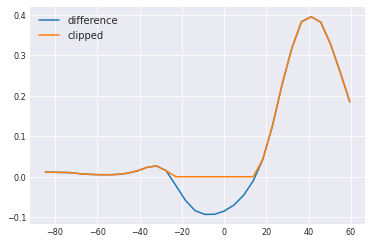

In [76]:
plt.plot(wave_H_dopp,paper_cc[43,41:]-paper_cc[7,41:],label='difference')
diff_profile = (paper_cc[43,41:]-paper_cc[7,41:])
diff_profile[diff_profile<0] = 0
plt.plot(wave_H_dopp,diff_profile,label='clipped')
plt.legend()

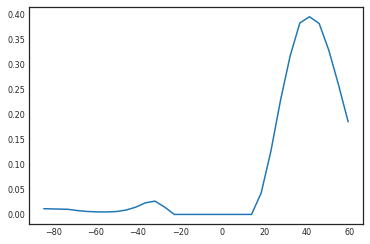

In [118]:
plt.plot(wave_H_dopp,diff_profile_spicule[7,:])

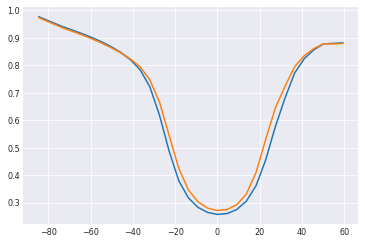

In [47]:
plt.plot(wave_H_dopp,paper_cc[43,41:])
plt.plot(wave_H_dopp,paper_cc[12,41:])

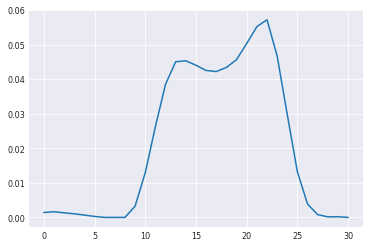

In [43]:
plt.plot(diff_profile_spicule)

In [163]:
lc_width_refined = np.zeros(50)
new_lam_cog_refined = lc_width_refined*0
for centers in range(50):
    if centers == 21:
        continue
    sp = paper_cc[centers,41:]
    lc_width_refined[centers] = lp_halpha_core_width(sp,ll)
    if lam_cog_refined[centers]>0:
        new_lam_cog_refined[centers] = lam_cog_refined[centers]+5
    else:
        new_lam_cog_refined[centers] = lam_cog_refined[centers]-5

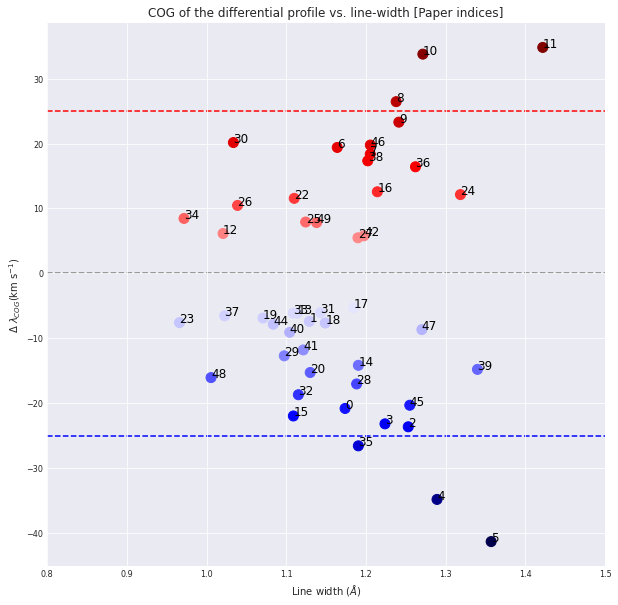

In [435]:
##----Outdated indices, but relevant if we want to compare older Fig. 2 and Fig. 3 in the paper---
plt.style.use('seaborn-darkgrid')
#yticks=[-40,-25,-15,0,15,25,35]
colors = new_lam_cog_refined
RP = np.arange(50)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(lc_width_refined, new_lam_cog_refined, s =100.,c=colors,marker='o',cmap='seismic',alpha=1)
ax.set_xlabel(r'Line width ($\AA$)')
ax.set_ylabel(r'$\Delta$ $\lambda_{COG}$(km s$^{-1}$)')
ax.axhline(y=0,color='gray',linestyle='--',zorder=-1)
ax.axhline(y=25,color='red',linestyle='--',zorder=-1)
ax.axhline(y=-25,color='blue',linestyle='--',zorder=-1)
ax.set_xlim([0.8,1.5])
ax.set_title('COG of the differential profile vs. line-width [Paper indices]')
#ax.set_yticks(yticks)
for i, txt in enumerate(RP):
    if i == 21:
        continue
    ax.annotate(txt, (lc_width_refined[i], new_lam_cog_refined[i]),size=12,color='black')
#    ax.grid('on')
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/COG_diff_vs_Width_paper_indices.png')

In [164]:
diff_max = np.zeros(50)
max_inten_diff = diff_max*0
for centers in range(50):
    if centers == 43:
        continue
    diff_profile = (paper_cc[43,41:]-paper_cc[centers,41:]) # computing the differential profile.
    index_neg = np.where(diff_profile < 0.)
    diff_profile[index_neg]=0.
    #diff_max[centers] = wave_H_dopp[np.argmax(diff_profile_spicule)]
    max_inten_diff[centers]= np.max(diff_profile)

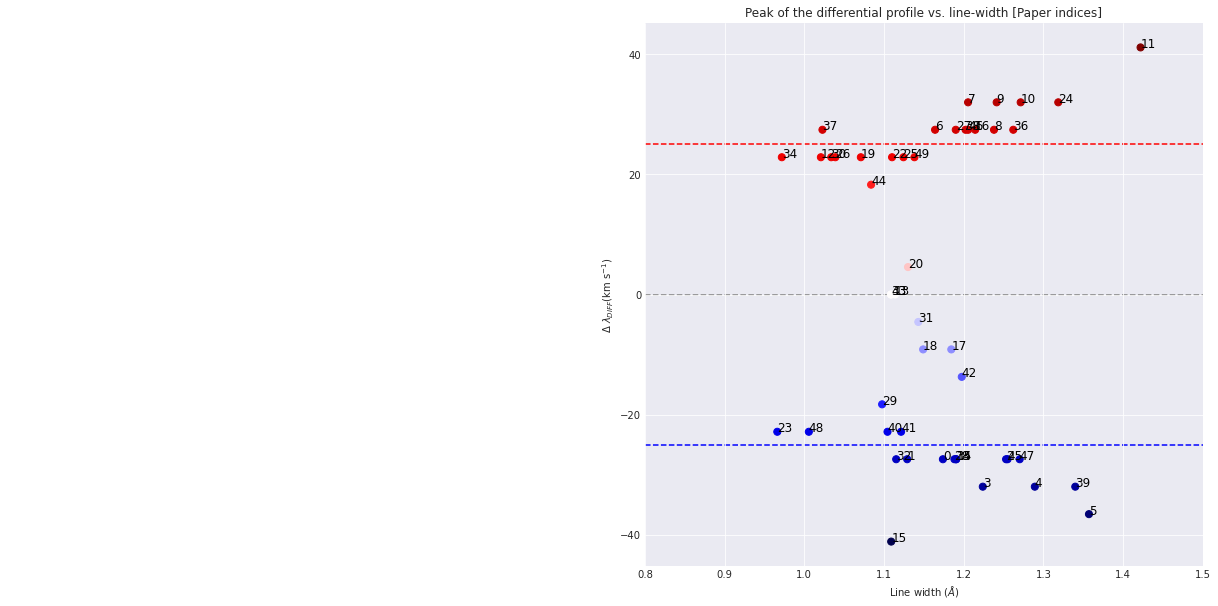

In [408]:
plt.style.use('seaborn-darkgrid')
#yticks=[-40,-25,-15,0,15,25,35]
colors = diff_max
RP = np.arange(50)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(lc_width_refined, diff_max, s =50.,c=colors,marker='o',cmap='seismic',alpha=1)
ax.set_xlabel(r'Line width ($\AA$)')
ax.set_ylabel(r'$\Delta$ $\lambda_{DIFF}$(km s$^{-1}$)')
ax.axhline(y=0,color='gray',linestyle='--',zorder=-1)
ax.axhline(y=25,color='red',linestyle='--',zorder=-1)
ax.axhline(y=-25,color='blue',linestyle='--',zorder=-1)
ax.set_xlim([0.8,1.5])
ax.set_title('Peak of the differential profile vs. line-width [Paper indices]')
#ax.set_yticks(yticks)
for i, txt in enumerate(RP):
    ax.annotate(txt, (lc_width_refined[i], diff_max[i]),size=12,color='black')
#    ax.grid('on')
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/Peak_diff_vs_Width_paper_indices.png')

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


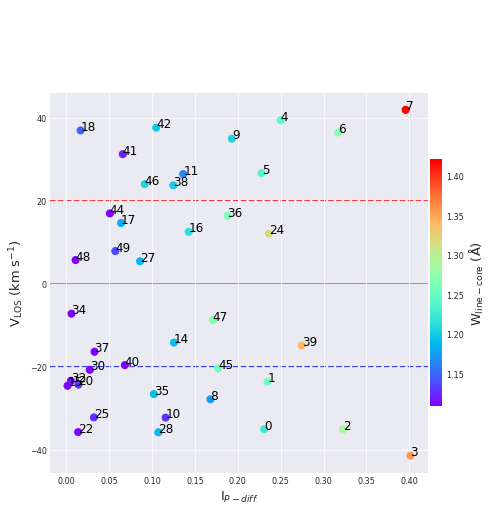

In [192]:
import matplotlib as mpl
plt.style.use('seaborn-darkgrid')
#yticks=[-40,-25,-15,0,15,25,35]
lc_width_refined[13] =np.nan
lc_width_refined[21] =np.nan
lc_width_refined[12] =np.nan
lc_width_refined[31] =np.nan

colorindex = np.where(lc_width_refined <= 1.108)
lc_width_refined[colorindex] = 1.108
colors = lc_width_refined
RP = np.arange(50)
fig, ax = plt.subplots(figsize=(8,8))
max_inten_diff[13]=np.nan
max_inten_diff[21]=np.nan
new_lam_cog_refined[13] =np.nan
new_lam_cog_refined[21] =np.nan
im1=ax.scatter(max_inten_diff, new_lam_cog_refined, s =50.,c=colors,marker='o',cmap='rainbow',alpha=1)
cb1=plt.colorbar(im1,pad=0.005,fraction = 0.15,shrink=0.65)
cb1.set_label(r'W$_{\mathrm{line-core}}$ ($\mathrm{\AA}$)',fontsize=13)
ax.set_xlabel(r'I$_{P-diff}$',fontsize=13)
ax.set_ylabel(r'V$_{\mathrm{LOS}}$ (km s$^{-1}$)',fontsize=13)
ax.axhline(y=0,color='gray',linestyle='-',zorder=-1)
ax.axhline(y=20,color='red',linestyle='--',zorder=-1)
ax.axhline(y=-20,color='blue',linestyle='--',zorder=-1)
#plt.colorbar()
#ax.set_xlim([-0.1,0.7])
#ax.set_title('Peak intensity vs. V$_{\mathrm{LOS}}$ ',fontsize=13)
#ax.set_yticks(yticks)
for i, txt in enumerate(RP):
    ax.annotate(txt, (max_inten_diff[i], new_lam_cog_refined[i]),size=12,color='black')
#plt.savefig('/mn/stornext/d9/souvikb/paper4_images/Velocity_vs_peak_width_revised.pdf',dpi=400,bbox_inches = 'tight',pad_innches=0.1)

In [191]:
lc_width_refined[43]

1.1086745064551997

(0.85, 1.5)

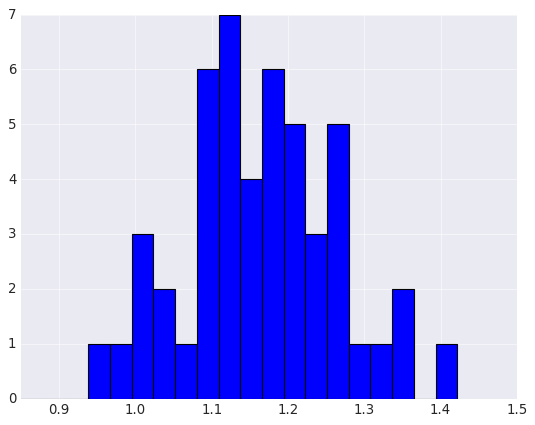

In [586]:
plt.hist(lc_width_refined,bins=50)
plt.xlim([0.85,1.5])

# Version with COG of differential profile (Not absolute value)

In [421]:
wav_indices =wave_H_dopp.shape
wt_I = np.zeros((50,wav_indices[0]))
I = wt_I*0
lam_cog_refined = np.zeros(50)
for centers in range(50):
    diff_profile_spicule = (paper_cc[43,41:]-paper_cc[centers,41:]) # computing the differential profile.
    for i in range(31):
        wt_I[centers,i] = wave_H_dopp[i]*diff_profile_spicule[i]
        I[centers,i] = diff_profile_spicule[i]
    lam_cog_refined[centers] = np.sum(wt_I[centers,:])/np.sum(I[centers,:])

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [422]:
lc_width_refined = np.zeros(50)
new_lam_cog_refined = lc_width_refined*0
for centers in range(50):
    if centers == 21:
        continue
    sp = paper_cc[centers,41:]
    lc_width_refined[centers] = lp_halpha_core_width(sp,ll)
    if lam_cog_refined[centers]>0:
        new_lam_cog_refined[centers] = lam_cog_refined[centers]+0
    else:
        new_lam_cog_refined[centers] = lam_cog_refined[centers]-0

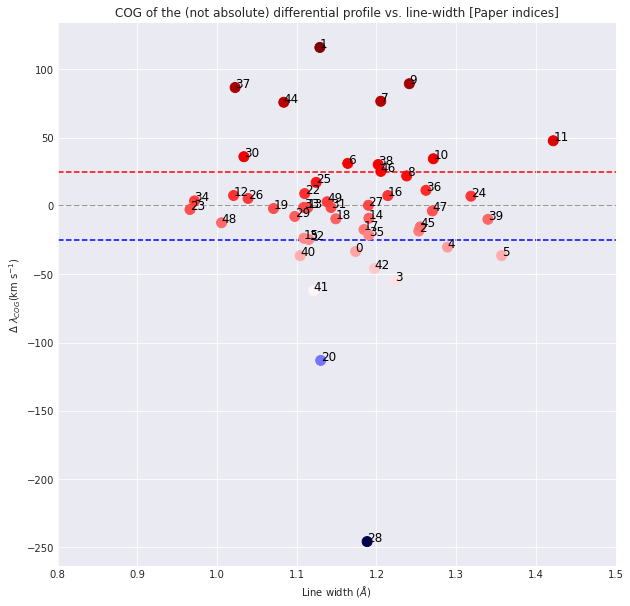

In [423]:
plt.style.use('seaborn-darkgrid')
#yticks=[-40,-25,-15,0,15,25,35]
colors = new_lam_cog_refined
RP = np.arange(50)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(lc_width_refined, new_lam_cog_refined, s =100.,c=colors,marker='o',cmap='seismic',alpha=1)
ax.set_xlabel(r'Line width ($\AA$)')
ax.set_ylabel(r'$\Delta$ $\lambda_{COG}$(km s$^{-1}$)')
ax.axhline(y=0,color='gray',linestyle='--',zorder=-1)
ax.axhline(y=25,color='red',linestyle='--',zorder=-1)
ax.axhline(y=-25,color='blue',linestyle='--',zorder=-1)
ax.set_xlim([0.8,1.5])
ax.set_title('COG of the (not absolute) differential profile vs. line-width [Paper indices]')
#ax.set_yticks(yticks)
for i, txt in enumerate(RP):
    if i == 21:
        continue
    ax.annotate(txt, (lc_width_refined[i], new_lam_cog_refined[i]),size=12,color='black')
#    ax.grid('on')
#plt.savefig('/mn/stornext/d9/souvikb/paper4_images/COG_diff_vs_Width_paper_indices.png')

In [166]:
wt_I = np.zeros((50,wav_indices[0]))
I =wt_I*0.
lam_cog1 =np.zeros((50))
for centers in range(50):
    for i in range(30):
        wt_I[centers,i] = wave_H_dopp[i]*(paper_cc[centers,41]-paper_cc[centers,41+i])#paper_cc[centers,41]-
        I[centers,i] = (paper_cc[centers,41]-paper_cc[centers,41+i])#paper_cc[centers,41]-
    lam_cog1[centers] = np.sum(wt_I[centers,:])/np.sum(I[centers,:])
#     lam_cog1[centers
    if lam_cog1[centers]>0:
        lam_cog1[centers]=lam_cog1[centers]+4.9
    else:
        lam_cog1[centers]=lam_cog1[centers]-4.9

# plot as per the boss's suggestion


In [167]:
nlam = len(wave_H_dopp_new)
rows = 10
cols = 5
in_text = 10

In [168]:
import matplotlib
matplotlib.rc('xtick', labelsize=8)     
matplotlib.rc('ytick', labelsize=8)
grps = [0,1,2,3,
        4,5,6,7]
#--old nomenclature-- follow Context_plot.ipynb

clrs = ['blue','blue','blue','blue',
       'red','red','red','red']
clr_dic = dict(zip(grps, clrs))

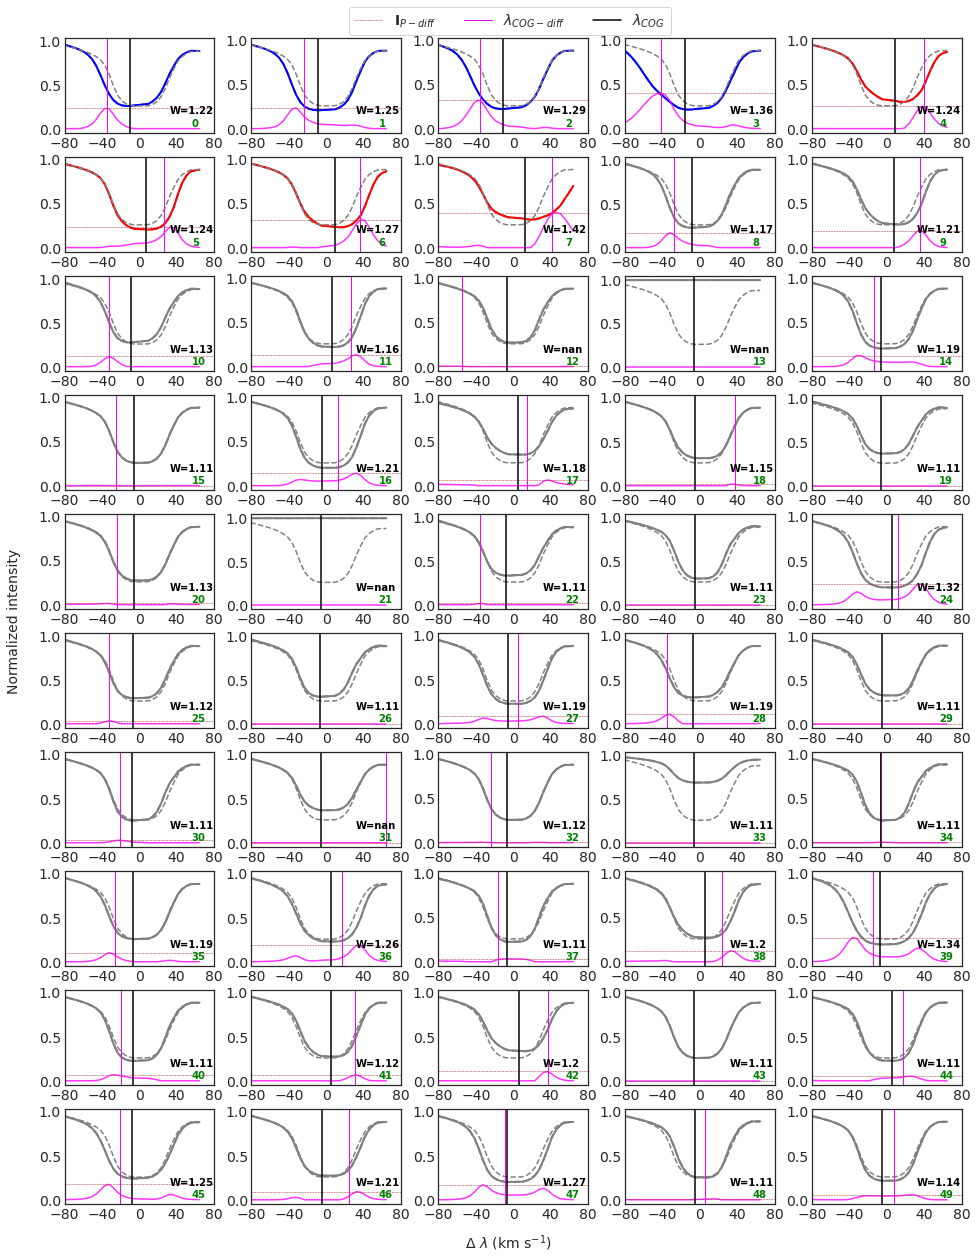

In [185]:
plt.style.use('seaborn-white')
legend_properties = {'weight':'bold',"size":14}
fig, axs = plt.subplots(rows, cols, figsize=(14,18))
fig.subplots_adjust(hspace = 0.25, wspace=0.25,left=0.06,right=0.95,top=0.95,bottom=0.05)
ax=axs.ravel()
for k in range(50):
    ax[k].plot(wave_H_dopp_new, paper_cc[k,41:], color='Grey', linewidth=2, linestyle='--',)
    ax[k].plot(wave_H_dopp_new, paper_cc[k,41:], color=clr_dic.get(k,'Grey'), linewidth=2)
    ax[k].plot(wave_H_dopp_new, paper_cc[43,41:],color='Grey',linestyle='dashed')
    #ax[k].plot(wave_H_dopp_new, np.abs(paper_cc[k,41:]-paper_cc[43,41:]),alpha=0.8,color='magenta')
    ax[k].plot(wave_H_dopp_new, diff_profile_spicule[k,:],alpha=0.8,color='magenta')
    #ax[k].axvline(x=0,color='black',linewidth = 1)
    ax[k].axhline(y=max_inten_diff[k],linewidth=0.5,linestyle='dashed',label=r'I$_{P-diff}$',color='#A52A2A')
    ax[k].axvline(x=new_lam_cog_refined[k], linewidth=1,linestyle='-',label=r'$\lambda_{COG-diff}$',color='magenta')
    ax[k].axvline(x=lam_cog1[k],label=r'$\lambda_{COG}$',color='black')
    ax[k].text(.85, .065, str(k), transform=ax[k].transAxes, size=in_text,color='Green',fontweight='bold')
    ax[k].text(.7, .2, 'W='+str(round(lc_width_refined[k],2)), transform=ax[k].transAxes, size=in_text,color='black',fontweight='bold')
    ax[k].set_xlim([-80,80])
    ax[k].set_xticks([-80,-40,0,40,80])
    ax[k].tick_params(axis='both', which='major', labelsize=14)
    if k ==0:
        ax[k].legend(loc="best",frameon=True,ncol=3,bbox_to_anchor=(4.1, 1.4),bbox_transform=ax[k].transAxes,prop=legend_properties)

#fig.text(0.5, 0.97, r'H $\alpha$ clusters', ha='center', va='center', rotation='horizontal',size=12,fontweight='bold')
fig.text(0.5, 0.02, r'$\Delta$ $\lambda$ (km s$^{-1}$)', ha='center', va='center', rotation='horizontal',size=14)
fig.text(0.01, 0.5, 'Normalized intensity', ha='center', va='center', rotation='vertical',size=14)
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/H_alpha_all_clusters_enhanced_diff.pdf',dpi=400)
plt.show()

In [139]:
diff_profile_spicule.shape

(31,)

In [138]:
lam_cog1[0:8]

array([ -8.48184337,  -9.95665579, -11.03920734, -15.92812384,
         6.85774184,   8.74413597,   9.16666131,  12.43805112])

# Ca II K cluster plot


In [14]:
nlam = len(wave_Ca_dopp)
rows = 10
cols = 5
in_text = 10

In [15]:
import matplotlib
matplotlib.rc('xtick', labelsize=8)     
matplotlib.rc('ytick', labelsize=8)
grps = [0,1,2,3,
        4,5,6,7]
#--old nomenclature-- follow Context_plot.ipynb

clrs = ['blue','blue','blue','blue',
       'red','red','red','red']
clr_dic = dict(zip(grps, clrs))

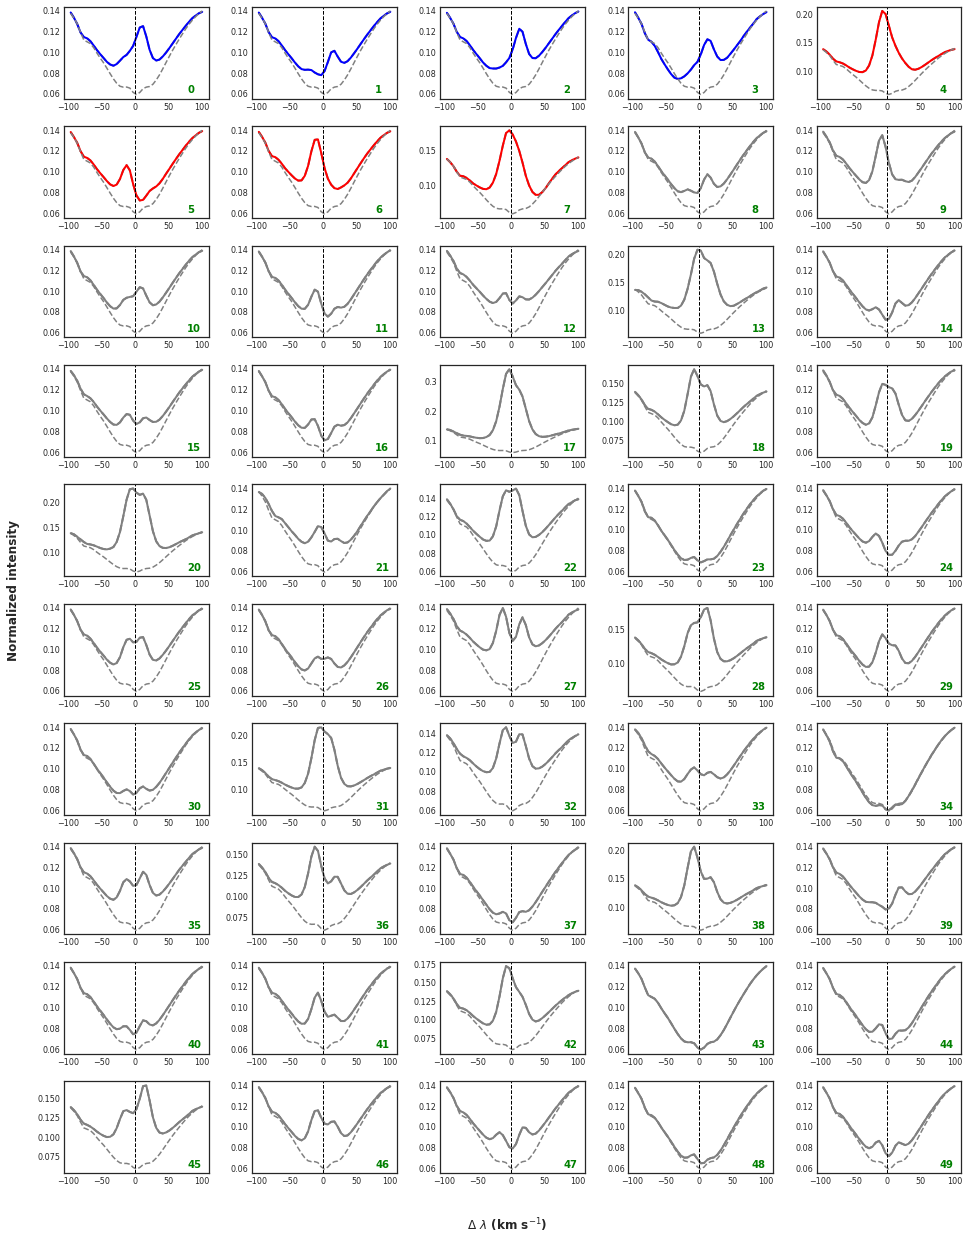

In [18]:
plt.style.use('seaborn-white')
fig, axs = plt.subplots(rows, cols, figsize=(14,18))
fig.subplots_adjust(hspace = 0.3, wspace=0.3,left=0.06,right=0.95,top=0.95,bottom=0.05)
ax=axs.ravel()
for k in range(50):
    ax[k].plot(wave_Ca_dopp, paper_cc[k,:41], color='Grey', linewidth=2, linestyle='--',)
    ax[k].plot(wave_Ca_dopp, paper_cc[k,:41], color=clr_dic.get(k,'Grey'), linewidth=2)
    ax[k].plot(wave_Ca_dopp, paper_cc[43,:41],color='Grey',linestyle='dashed')
    ax[k].axvline(x=0,color='black',linewidth = 1,linestyle='dashed')
    ax[k].text(.85, .065, str(k), transform=ax[k].transAxes, size=in_text,color='Green',fontweight='bold')

#fig.text(0.5, 0.97, r'Ca II k clusters', ha='center', va='center', rotation='horizontal',size=12,fontweight='bold')
fig.text(0.5, 0.01, r'$\Delta$ $\lambda$ (km s$^{-1}$)', ha='center', va='center', rotation='horizontal',size=12,fontweight='bold')
fig.text(0.01, 0.5, 'Normalized intensity', ha='center', va='center', rotation='vertical',size=12,fontweight='bold')
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/Cak_clusters_revised.pdf',dpi=400)
plt.show()